NSV571, vacuum

NKT

Back to BeamCo-substrate VVC

Output QWP+Pol at final pupil (downstream of field stop)

Aeroglaze Lyot stop

Circumventing attenuator now

Increased camera bias to 300 (to avoid clipping)

Repeat to hopefully correct bias/dark-correction related issues

In [1]:
%matplotlib inline

import poppy
poppy.conf.use_cupy = False

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm

import numpy as np
from scoobpy import utils, iefc

from magpyx.utils import ImageStream
from magpyx.dm import control, dmutils
from magpyx import imutils, instrument

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from purepyindi2 import IndiClient, SwitchState #INDIClient
from time import sleep

from skimage.registration import phase_cross_correlation
from scipy.ndimage import center_of_mass

import deepdish as dd

/opt/conda/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
from importlib import reload
reload(iefc)
reload(control)

<module 'magpyx.dm.control' from '/opt/MagAOX/source/magpyx/magpyx/dm/control.py'>

# Functions

In [3]:
def get_circular_mask(ceny, cenx, iwa, owa, pixscale, shape):
    idy, idx = np.indices(shape, dtype=float)
    idy -= ceny
    idx -= cenx
    idy = idy / pixscale # to lambda/D
    idx = idx / pixscale
    
    r_lambdaD = np.sqrt(idx**2 + idy**2)
    return (r_lambdaD >= iwa) & (r_lambdaD <= owa)

def get_semicircular_mask(ceny, cenx, iwa, owa, pixscale, shape, angle, iwa_margin=0):
    
    circ_mask = get_circular_mask(ceny, cenx, iwa, owa, pixscale, shape)
    
    idy, idx = np.indices(shape)
    
    angle_rad = np.deg2rad(angle)
    idxx = ((idx-cenx) * np.cos(angle_rad) - (idy-ceny) * np.sin(angle_rad))/pixscale
    idyy = ((idx-cenx) * np.sin(angle_rad) + (idy-ceny) * np.cos(angle_rad))/pixscale
    #theta = np.rad2deg(np.arctan2(idy - ceny - np.sin(angle_rad) * iwa_margin * iwa * pixscale,
    #                              idx - cenx - np.cos(angle_rad) * iwa_margin * iwa * pixscale)) + 180
    #theta_mask = (theta >= (angle)) & (theta < (angle + 180))
    #return theta
    mask = idxx >= (iwa_margin*iwa)
    
    return mask * circ_mask

def get_radial_dist(shape, scaleyx=(1.0, 1.0), cenyx=None):
    '''
    Compute the radial separation of each pixel
    from the center of a 2D array, and optionally 
    scale in x and y.
    '''
    indices = np.indices(shape)
    if cenyx is None:
        cenyx = ( (shape[0] - 1) / 2., (shape[1] - 1)  / 2.)
    radial = np.sqrt( (scaleyx[0]*(indices[0] - cenyx[0]))**2 + (scaleyx[1]*(indices[1] - cenyx[1]))**2 )
    return radial

def get_radial_contrast(im, mask, nbins=50, cenyx=None):
    radial = get_radial_dist(im.shape, cenyx=cenyx)
    bins = np.linspace(0, radial.max(), num=nbins, endpoint=True)
    digrad = np.digitize(radial, bins)
    profile = np.asarray([np.mean(im[ (digrad == i) & mask]) for i in np.unique(digrad)])
    return bins, profile

def compute_offset(imref, image, mask, upsample=100):
    (y,x),_,_ = phase_cross_correlation(imref*mask, image*mask,
                                        upsample_factor=upsample,
                                        normalization=None)
    return y,x

def get_core_centroid(im, mask):
    com_yx = center_of_mass(im * mask)
    return int(np.rint(com_yx[0])), int(np.rint(com_yx[1]))

def get_speckle_centroid(im, mask):
    ymax, xmax = np.where( (im*mask) == (im*mask).max() )
    return np.squeeze([ymax[0], xmax[0]])

def autocalibrate_pre(im_aligned, camstream, client, calib_params, realign=True, satval=55000, skip_fsm=False, manual_intervention=False):
    '''
    Basic idea:
    * Drive PSF off-axis
    * Adjust settings (gain, exposure time, attenuation, etc) such that core is not saturated
    * Image 1: non-saturated core
    * Adjust settings with KNOWN scaling (exposure time, attenuation) to get high SNR on speckles
    * Image 2: high-SNR speckles (but saturated core)
    * Then adjust settings with UNKNOWN scaling (gain, anything else) to the mode they'll be fixed at for DH digging
    * Image 3: high-SNR speckles in DH mode
    
    Then, what we want to know is the contrast normalization for the final settings (image 3)
    * ratio of speckles in image 3 to image 2 gives attenuation factor for unknown settings = atten
    * ratio of speckles in image 2 to core in image 1 gives contrast of the speckle = contrast
    So that the normalization is
    * contrast / attenuation
    
    '''
    
    # drive PSF off-axis
    if not skip_fsm:
        print('Driving PSF off-axis')
        move_relative(client, 'stagepiezo.stagepupil_x_pos', 200)
        sleep(5)
        move_relative(client, 'stagepiezo.stagepupil_y_pos', 200)
        sleep(5)

    print('Adjusting for non-saturated core')
    camstream.set_attenuation(calib_params['atten_min'], wait=5)
    camstream.set_exposure_time(calib_params['exp_min'], wait=5)
    camstream.set_gain(calib_params['gain_min'], wait=5)
        
    print('Taking measurements at settings for non-saturated core')
    im_core = np.mean(camstream.grab_many(100), axis=0)
    
    im_core_bg = take_bg(n=100, nwait=20)

    print('Adjusting settings with known scaling for high SNR speckle measurement')
    camstream.set_attenuation(calib_params['atten_max'], wait=5)
    camstream.set_exposure_time(calib_params['exp_max'], wait=5)
    im_speckle = np.mean(camstream.grab_many(100), axis=0)
    
    im_speckle_bg = take_bg(n=100, nwait=20)
    
    print('Going to DH-digging settings (settings with unknown scaling) to get attenuation factor')
    if manual_intervention:
        input('Awaiting manual intervention (adjust to DH settings)')
    camstream.set_gain(calib_params['gain_max'], wait=5)
    camstream.set_exposure_time(calib_params['exp_dh'], wait=5) # make this adjustable!!!!!
    im_dh = np.mean(camstream.grab_many(100), axis=0)
    
    im_dh_bg = take_bg(n=100, nwait=20)
    
    return im_core, im_speckle, im_dh, im_core_bg, im_speckle_bg, im_dh_bg


def process_calibration_measurements(im_core, im_speckle, im_dh, calib_params, skip_conv=False):
    '''
    Use the measured attenuation in the reference speckle to determine the absolute counts per second in the core
    in the DH polarization state from the measured core in the calibration polarization state
    
    im_calibpol_tmax_gmax
    '''
    plate_scale = calib_params['plate_scale']
    
    # they're already in counts per sec
    core_calib_cps = im_core 
    speckle_calib_cps = im_speckle 
    speckle_dh_cps = im_dh
    
    # pick out the slices
    coreyx = get_core_centroid(im_core, calib_params['mask_core'])
    speckleyx = get_speckle_centroid(im_speckle, calib_params['mask_speckle'])
    
    extent_speckle = calib_params['cutout_extent_speckle']
    extent_core = calib_params['cutout_extent_core']
    speckle_slice = (slice(speckleyx[0]-extent_speckle//2, speckleyx[0]+extent_speckle//2),
                     slice(speckleyx[1]-extent_speckle//2, speckleyx[1]+extent_speckle//2))
    core_slice = (slice(coreyx[0]-extent_core//2, coreyx[0]+extent_core//2),
                  slice(coreyx[1]-extent_core//2, coreyx[1]+extent_core//2))
    print(speckle_slice, core_slice)
        
    # convolve with lambda/D gaussian(?) kernel
    apkernel = iefc.get_aperture_kernel(plate_scale, core_calib_cps.shape, oversample=16)
    
    if not skip_conv:
        core_calib_cps_apconv = imutils.convolve_fft(core_calib_cps, apkernel, force_real=True)
        speckle_calib_cps_apconv = imutils.convolve_fft(speckle_calib_cps, apkernel, force_real=True)
        speckle_dh_cps_apconv = imutils.convolve_fft(speckle_dh_cps, apkernel, force_real=True)
    else:
        core_calib_cps_apconv = core_calib_cps
        speckle_calib_cps_apconv = speckle_calib_cps
        speckle_dh_cps_apconv = speckle_dh_cps
    
    # compute the attenuation (due to gain, polarization, etc)
    # replace max with sum here
    atten = speckle_calib_cps_apconv[speckle_slice].sum()  / speckle_dh_cps_apconv[speckle_slice].sum()
    
    # compute the core CPS in the DH polarization
    core_cps_dh = core_calib_cps_apconv[core_slice].max() / atten
    
    # return all the things
    return {
        'core_slice' : core_slice,
        'speckle_slice' : speckle_slice,
        'core_calib_cps_apconv' : core_calib_cps_apconv,
        'speckle_calib_cps_apconv' : speckle_calib_cps_apconv,
        'speckle_dh_cps_apconv' : speckle_dh_cps_apconv,
        'atten' : atten,
        'core_cps_dh' : core_cps_dh,
        'coreyx' : coreyx,
        'speckleyx' : speckleyx
    }
    
    
def display_calibration(calib_proc, im_core, im_speckle, im_dh):
    #cross checks of everything
    coreyx = calib_proc['coreyx']
    speckleyx = calib_proc['speckleyx']
    core_slice = calib_proc['core_slice']
    speckle_slice = calib_proc['speckle_slice']
    
    
    # plot of one raw image, with core and speckle positions marked
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(calib_proc['speckle_calib_cps_apconv'], norm=LogNorm())
    coreyx = calib_proc['coreyx']
    speckleyx = calib_proc['speckleyx']
    ax.scatter(coreyx[1], coreyx[0], marker='X', c='C1', label='core')
    ax.scatter(speckleyx[1], speckleyx[0], marker='X', c='C3', label='ref speckle')
    fig.legend()
    
    # plot the 3 sliced images (raw images in counts)
    fig, axes = plt.subplots(1,3,figsize=(15,4))
    im = axes[0].imshow(im_core[core_slice] * calib_params['exp_min'] * 10**(-calib_params['atten_min']/10))
    axes[0].set_title('core slice, calib, counts')
    fig.colorbar(im, ax=axes[0])
    im = axes[1].imshow(im_speckle[speckle_slice] * calib_params['exp_max'] * 10**(-calib_params['atten_max']/10))
    axes[1].set_title('speckle slice, calib, counts')
    fig.colorbar(im, ax=axes[1])
    im = axes[2].imshow(im_dh[speckle_slice] * calib_params['exp_dh'] * 10**(-calib_params['atten_max']/10))
    axes[2].set_title('speckle slice, DH, counts')
    fig.colorbar(im, ax=axes[2])
    
    # plot the 3 sliced images (aperture convolved, counts per second)
    fig, axes = plt.subplots(1,3,figsize=(15,4))
    axes[0].imshow(calib_proc['core_calib_cps_apconv'][core_slice])
    axes[0].set_title('core slice, calib, ap-convolved, cps')
    axes[1].imshow(calib_proc['speckle_calib_cps_apconv'][speckle_slice])
    axes[1].set_title('speckle slice, calib, ap-convolved, cps')
    axes[2].imshow(calib_proc['speckle_dh_cps_apconv'][speckle_slice])
    axes[2].set_title('speckle slice, DH, ap-convolved, cps')
    
    # cross-checks
    core_cps_dh = calib_proc['core_cps_dh']
    speckle_contrast = calib_proc['speckle_dh_cps_apconv'][speckle_slice].max() / core_cps_dh
    core_contrast = calib_proc['core_calib_cps_apconv'][core_slice].max()  / calib_proc['atten'] / core_cps_dh
    
    # print out the attenuation factor, the core normalization, the core contrast (better = 1), and the speckle contrast
    print(f'Attenuation factor: {calib_proc["atten"]}')
    print(f'Core CPS: {calib_proc["core_cps_dh"]}')
    print(f'Speckle contrast: {speckle_contrast}')
    print(f'Core contrast: {core_contrast}')
    
class CameraStream(ImageStream):
    
    def __init__(self, name, client, device, fiberatten, sliceyx=None):
        super().__init__(name)
        
        self.client = client
        self.device = device
        self.fiberatten = fiberatten
        if sliceyx is None:
            sliceyx = (slice(None,None), slice(None,None))
        self.sliceyx = sliceyx
        self.exp_time = None
        self.atten = None
        
    def set_exposure_time(self, exp, wait=None):
        #client[f'{self.device}.exptime.target'] = exp
        client[f'{self.device}.exptime.exptime'] = exp
        if wait is not None:
            sleep(wait)
        # update tracked exposure tiem
        self.get_exposure_time()
        
    def set_attenuation(self, atten, wait=None):
        client[f'{self.fiberatten}.atten.target'] = atten
        if wait is not None:
            sleep(wait)
        # update tracked attenuation
        self.atten = 10**(-atten/10.)
        
    def set_gain(self, gain, wait=None):
        client[f'{self.device}.gain.gain'] = gain
        if wait is not None:
            sleep(wait)
        # update tracked attenuation
        self.gain = gain #10**(-atten/10.)
        
    def get_exposure_time(self):
        t = client[f'{self.device}.exptime.exptime']
        #t = client[f'{self.device}.exptime.exptime']
        self.exp_time = t
        return t
    
    #def grab_latest(self):
    #    # grab_many and grab_after both call grab_latest internally
    #    out = super().grab_latest()
    #    return downscale_local_mean(out.astype(float), (2,2)) / self.exp_time
    
    def grab_latest(self):
        # grab_many and grab_after both call grab_latest internally
        out = super().grab_latest()[self.sliceyx]
        return out.astype(float) / self.exp_time / self.atten
    
    #def grab_many(self, n, cnt0_min=None):
    #    out = super().grab_many(n, cnt0_min=cnt0_min)
    #    return np.asarray(out, dtype=float) / self.exp_time
    
    #def grab_after(self, n, nwait):
    #    out = super().grab_after(n, nwait)
    #    return np.asarray(out, dtype=float) / self.exp_time
    
def move_relative(client, device, val):
    client[f'{device}.target'] = client[f'{device}.current'] + val
    
def move_linear(client, val):
    client['stagelinear.position.target'] = val
    
def move_linear_preset(client, preset):
    #client[f'stagelinear.presetName.{preset}'] = SwitchState.ON
    instrument.indi_send_and_wait(client,
                                  {f'stagelinear.presetName.{preset}' : SwitchState0.ON},
                                  timeout=30)
    
def take_dark(client, camstream, nimages, restore=True):
    move_linear_preset(client, 'block_in')
    sleep(5) # not sure
    dark = np.mean(camstream.grab_many(nimages), axis=0)
    if restore:
        move_linear_preset(client, 'block_out')
    return dark

def take_bg(n=100, nwait=2):
    move_linear_preset(client0, 'block_in')
    imbg = np.mean(camstream.grab_after(n, nwait=nwait), axis=0)
    move_linear_preset(client0, 'block_out')
    return imbg

def take_bg_atten(n=100, nwait=2):
    atten0 = np.abs(-np.log10(camstream.atten) * 10) # force positive for the -0.0 case
    camstream.set_attenuation(60, wait=10)
    move_linear_preset(client0, 'block_in')
    imbg = np.mean(camstream.grab_after(n, nwait=nwait), axis=0) * 10**(-(60-atten0)/10) #???
    move_linear_preset(client0, 'block_out')
    camstream.set_attenuation(atten0, wait=0)
    return imbg

def get_mean_contrast(imdh, imbg, mask, norm_cps, rejectnegative=True):
    bg_sub = imdh-imbg
    if rejectnegative:
        bg_sub[bg_sub < 0] = np.nan
    return np.nanmean(bg_sub[mask]) / norm_cps

In [4]:
def save_dict_to_h5(filename, mydict):
    dd.io.save(filename, mydict)
    
def load_dict_from_h5(filename):
    return dd.io.load(filename)

# Setup

In [5]:
client0 = INDIClient('localhost', 7624)
client0.start()

client = IndiClient()
client.connect()
client.get_properties()

In [6]:
plate_scale = np.sqrt((87-78)**2 + (27-214)**2) / (30 * 2) * 4.64/3.76
print(plate_scale)

3.8505511459476773


In [7]:
dmch = ImageStream('dm00disp')
dmch1 = ImageStream('dm00disp01')
dmch3 = ImageStream('dm00disp03')
dmch4 = ImageStream('dm00disp04')
dmch5 = ImageStream('dm00disp05')
dmch6 = ImageStream('dm00disp06')

allch = [dmch, dmch1, dmch3, dmch4, dmch5, dmch6]
allchbutdh = [dmch, dmch3, dmch4, dmch5, dmch6]

dm_map, dm_mask = utils.get_kilo_map_mask()
#zterms = utils.get_kilo_zernikes()

In [8]:
camstream = CameraStream('nsvcam', client, 'nsv571', 'fiberatten')

In [9]:
camstream.set_exposure_time(10e-3, wait=1)
camstream.set_gain(120, wait=1)
camstream.set_attenuation(0, wait=0)

In [10]:
iefc.zero_channels(allch)

# automated calibration


1. PSF off-axis [fixed step], Pol driven such that the core is non-saturated [min exposure time] ---> measure
2. Same state, longer exposure to get high SNR on speckle(s) ---> measure
3. Pol driven to maximize throughput (DH pol), short exposure to avoid saturating speckle(s) ---> measure
4. Pick out core and speckle slice, compute polarization attenuation factor from speckles, compute core CPS in DH pol
5. Drive PSF back behind the VVC (drive to reference image)


manually align to VVC

In [265]:
#move_relative(client, 'stagepiezo.stageqwp_pos', 50) # -34378L

In [35]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', -1) # -34378L

In [45]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', 1)

In [11]:
#move_relative(client, 'stagepiezo.stagefold_pos', -50000) # + = in (left), - = out (right)

 automation starts here

In [13]:
dmch3.write(dh_cmd_good)

NameError: name 'dh_cmd_good' is not defined

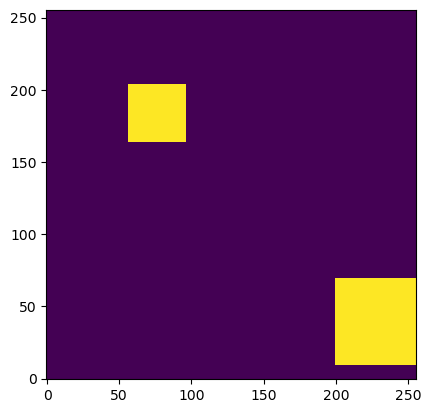

In [197]:
im_aligned = camstream.grab_latest()
shape = im_aligned.shape

mask = np.ones(shape, dtype=bool)
mask_speckle = np.zeros(shape, dtype=bool)
mask_speckle[184-20:184+20, 77-20:77+20] = 1
mask_core = np.zeros(shape, dtype=bool)
mask_core[30-20:30+40,220-20:220+40] = 1

calib_params = {
    'tilt_steps' : 60, # is this even used?
    'atten_max' : 0, #
    'atten_min' : 0,
    'gain_min' : 120,
    'gain_max' : 120,
    'cutout_extent_speckle' : 30,
    'cutout_extent_core' : 30,
    'mask_speckle' : mask_speckle,
    'mask_core' : mask_core,
    'plate_scale' : plate_scale,
    'exp_min' : 70e-6,
    'exp_max' : 0.05,
    'exp_dh' : 3e-4,
}

plt.imshow(mask_speckle + mask_core)

In [186]:
iefc.zero_channels(allch)

In [196]:
camstream.set_exposure_time(0.05)

In [198]:
# exp_min and gain_min should be set that off-axis core is not saturated but also such that
# at exp_max and gain_max you get high SNR on the speckle (without saturating once you max the source brightness)
#camstream.set_gain(120, wait=3)
camstream.set_exposure_time(70e-6)

In [185]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 200) # -34378L

In [187]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', 200) # -34378L

In [199]:
%%time
im_core, im_speckle, im_dh, im_core_bg, im_speckle_bg, im_dh_bg = autocalibrate_pre(im_aligned, camstream, client,
                                               calib_params, skip_fsm=True,
                                               manual_intervention=True,
                                               realign=False)

Adjusting for non-saturated core
Taking measurements at settings for non-saturated core
Adjusting settings with known scaling for high SNR speckle measurement
Going to DH-digging settings (settings with unknown scaling) to get attenuation factor
Awaiting manual intervention (adjust to DH settings)
CPU times: user 747 ms, sys: 0 ns, total: 747 ms
Wall time: 3min


In [457]:
norm_cps = 1./2.050591783215005e-12

(slice(155, 185, None), slice(81, 111, None)) (slice(43, 73, None), slice(200, 230, None))
Attenuation factor: 0.000948549271762165
Core CPS: 487664101741.4775
Speckle contrast: 0.00031988548287559677
Core contrast: 1.0
2.050591783215005e-12


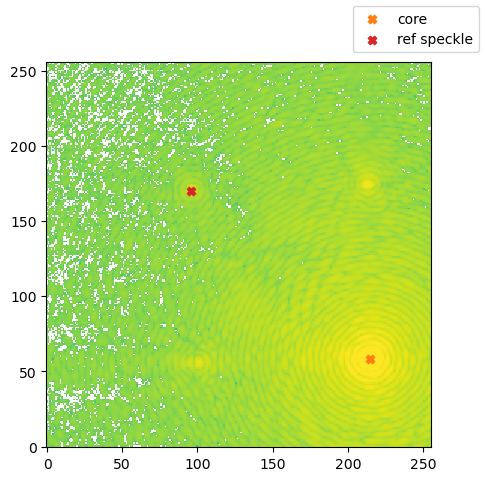

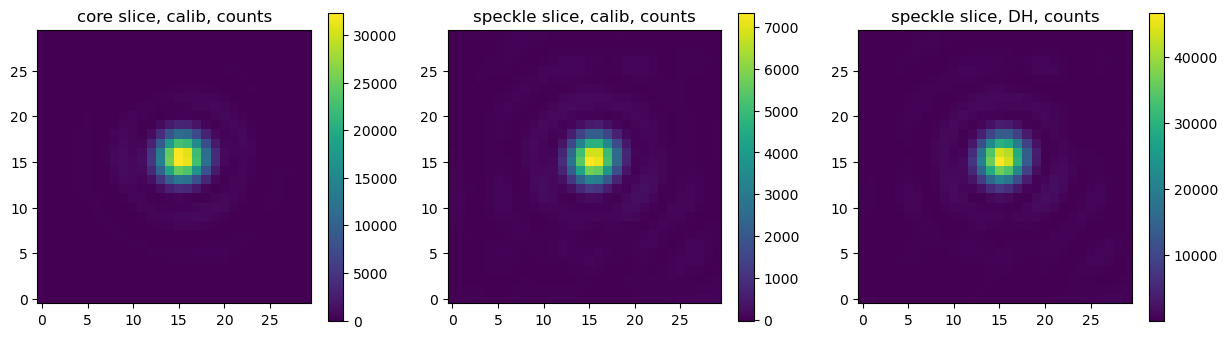

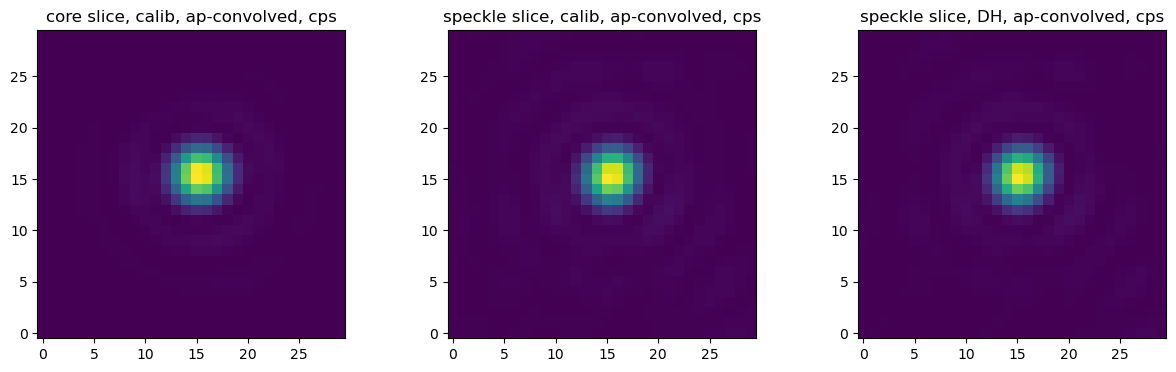

In [200]:
calib_proc = process_calibration_measurements(im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg,
                                              calib_params, skip_conv=True)

display_calibration(calib_proc, im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg)

norm_cps = calib_proc['core_cps_dh']
print(1/norm_cps)

In [68]:
camstream.set_exposure_time(0.05)

In [69]:
camstream.set_gain(120)

In [458]:
imbg = take_bg()

In [459]:
print(np.mean(imbg)/norm_cps)

6.849811448675439e-08


save all the things!

In [201]:
basedir = 'iefc_2024_05_30_NKT_2pcent_andfriends_NSV571_BeamCoSubstrateVVC_aeroglazeLS_vacuum'

In [202]:
import os
os.mkdir(basedir)

FileExistsError: [Errno 17] File exists: 'iefc_2024_05_30_NKT_2pcent_andfriends_NSV571_BeamCoSubstrateVVC_aeroglazeLS_vacuum'

In [203]:
allcalib = {
    'calib_params' : calib_params,
    'calib_proc' : calib_proc,
    'im_core' : im_core,
    'im_speckle' : im_speckle,
    'im_dh' : im_dh,
    'im_core_bg' : im_core_bg,
    'im_speckle_bg' : im_speckle_bg,
    'im_dh_bg' : im_dh_bg,
    'im_bg' : imbg,
}

In [204]:
save_dict_to_h5(os.path.join(basedir, 'allcalib.h5'), allcalib)

reset alignment

In [229]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 1) # -34378L

In [227]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', -1) # -34378L

### off-axis throughput measurement

* Slowly walk PSF off-axis (2-15 lambda/D-ish) and measure core (can't be saturated)

In [59]:
def walk_and_measure(camstream, client, device, step, nstep):
    #steps = np.linspace(step,step*nstep,num=nstep, endpoint=True)
    allims = []
    for n in range(nstep):
        move_relative(client, device, step)
        sleep(5)
        im = np.mean(camstream.grab_many(100),axis=0)
        allims.append(im)
    return allims

In [59]:
# set such that the core won't saturate
camstream.set_exposure_time(10e-3, wait=1)
camstream.set_gain(120, wait=1)
camstream.set_attenuation(32, wait=5)

In [60]:
offset_ims = walk_and_measure(camstream, client, 'stagepiezo.stagepupil_x_pos', 5, 30)

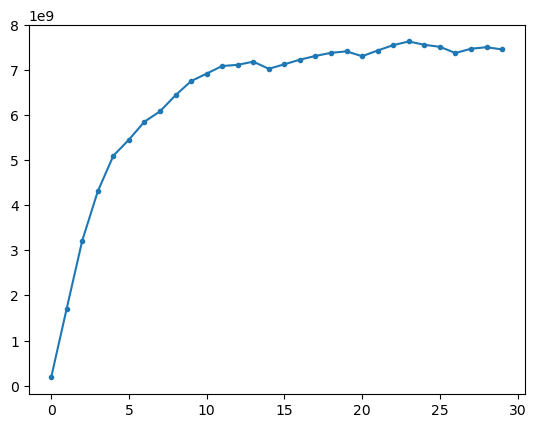

In [61]:
plt.plot(np.max(offset_ims,axis=(-2,-1)), marker='.')

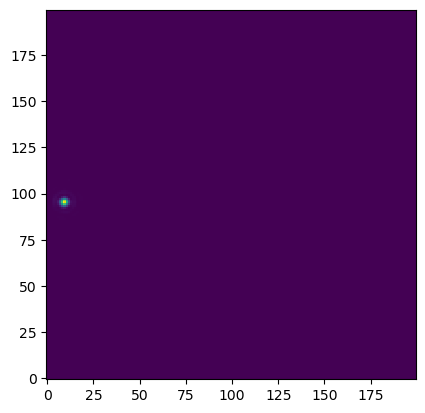

In [62]:
plt.imshow(offset_ims[-1])

In [63]:
save_dict_to_h5(os.path.join(basedir, 'offset_psfs.h5'), offset_ims)

# DH 1

calibration parameters

In [234]:
atten = 0
#camstream.set_attenuation(atten, wait=5)
camstream.set_exposure_time(1e-3, wait=5)
t1 = camstream.get_exposure_time() * 10**(-atten/10)

In [235]:
print(f'Contrast limit at this exposure time ~ {2/1e-3/norm_cps}')

Contrast limit at this exposure time ~ 4.10118356643001e-09


In [236]:
iefc.zero_channels(allch)

calibrate

In [256]:
# move field stop in (this time)
move_relative(client, 'stagepiezo.stagefold_pos', -20) # + = in (left), - = out (right)

In [259]:
%%time
#iefc.zero_channels(allchbutdh)

hval = 0.002
pval = 0.002
num = 3
alpha = 2#0
fmin = 2
fmax = 16
navg = 1
dmdelay = 4

im_slice = (slice(None), slice(None))
region_slice = (slice(None), slice(None), slice(None), slice(None))
weight = np.ones_like(imbg)

probes1 = iefc.get_random_probes(pval, alpha, dm_mask, fmask=None, fmin=fmin, fmax=fmax, nprobe=num)#fmask


respM1, respM_combined, hmodes, hcmds = iefc.get_combined_response_matrix(camstream, dmch4, dmch5, probes1,
                                                                         hval, weight, region_slice,
                                                                         im_slice, navg=navg, dmdelay=dmdelay,
                                                                         nrepeat=1, gauss_sigma=None)

50/1024
100/1024
150/1024
200/1024
250/1024
300/1024
350/1024
400/1024
450/1024
500/1024
550/1024
600/1024
650/1024
700/1024
750/1024
800/1024
850/1024
900/1024
950/1024
1000/1024
CPU times: user 10.5 s, sys: 1.97 s, total: 12.5 s
Wall time: 14min 58s


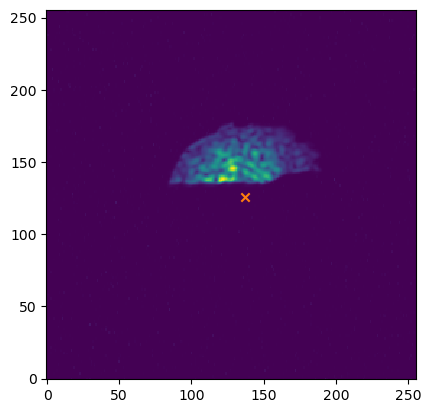

In [260]:
coreyx = (126, 137.)
plt.imshow(np.sqrt(np.mean(respM1**2, axis=(0,1))))
plt.scatter(coreyx[1], coreyx[0], marker='x', c='C1')

In [498]:
ctrldict['ctrlmat'].shape

(952, 4505)

In [500]:
hmodes.shape

(1024, 1024)

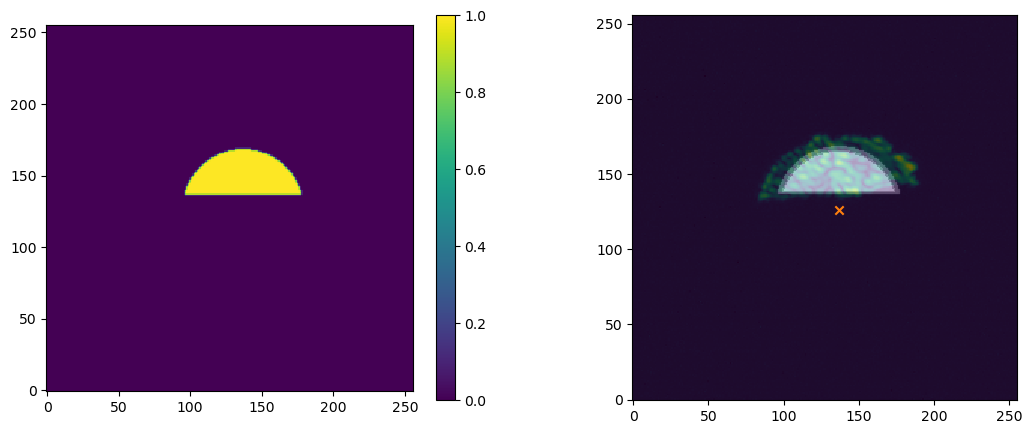

In [261]:
# choose wfs window
im = np.mean(camstream.grab_many(10),axis=0)

ceny, cenx = coreyx
angle = -90

# larger DH
iwa_lambdaD = 2.5
owa_lambdaD = 11

dh_mask = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
weighting0 = imutils.gauss_convolve(dh_mask.astype(float), 0.5)


# smaller DH
iwa_lambdaD = 2.7
owa_lambdaD = 10.3#
dh_mask = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
mask_dh = dh_mask

#dh_mask = get_circular_mask(ceny, cenx, 0, 20, plate_scale, im.shape)
#mask_dh = dh_mask


# DH mask proper
iwa_lambdaD = 3
owa_lambdaD = 10#
dh_mask_proper = get_semicircular_mask(ceny, cenx, iwa_lambdaD, owa_lambdaD, plate_scale, im.shape, angle, iwa_margin=1.105)
mask_dh_proper = dh_mask_proper


fig, axes = plt.subplots(1,2,figsize=(13,5))
pim = axes[0].imshow(weighting0[im_slice])
fig.colorbar(pim, ax=axes[0])

axes[1].imshow(np.sqrt(im), norm=LogNorm())
axes[1].imshow(mask_dh, alpha=0.25, cmap='Greys_r')
axes[1].imshow(mask_dh_proper, alpha=0.25, cmap='Greys_r')
axes[1].scatter(coreyx[1], coreyx[0], marker='x', c='C1')
axes[1].imshow(weighting0, alpha=0.25, cmap='Greys_r')

In [496]:
save_dict_to_h5(os.path.join(basedir, 'dh_mask_proper.h5'), dh_mask_proper)

In [262]:
imdh = np.mean(camstream.grab_many(10),axis=0) #/ t1
contrast_dh = np.mean((imdh-imbg)[mask_dh_proper]) / norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, mask_dh_proper, norm_cps, rejectnegative=True))

3.399372138907206e-06
3.399372138907206e-06


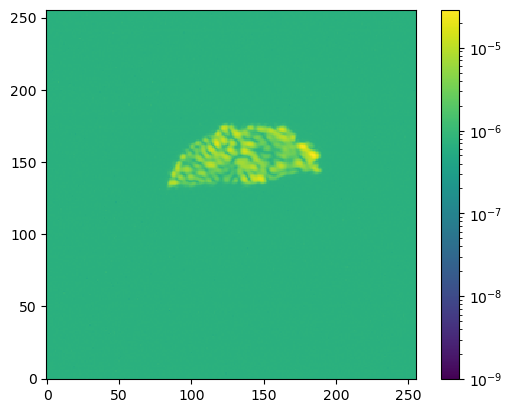

In [263]:
plt.imshow((imdh-imbg)/norm_cps, norm=LogNorm(vmin=1e-9))
plt.colorbar()

In [264]:
run_settings_1 = {
    'atten' : 0,
    'exptime' : 1e-3,
    'navg' : 4,
    'mask' : weighting0,
    'reg' : 1e-2,
    'scale' : 1.,
    'leak' : 0.1,
    'niter' : 15,
    'dobg' : True,
}

run_settings_2 = {
    'atten' : 0,
    'exptime' : 10e-3,
    'navg' : 4,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1,
    'leak' : 0.0,
    'niter' : 15,
    'dobg' : True,
}


run_settings_3 = {
    'atten' : 0,
    'exptime' : 10e-3,
    'navg' : 4,
    'mask' : 'residual',
    'reg' : 1e-2,
    'scale' : 2,
    'leak' : 0.0,
    'niter' : 10,
    'dobg' : False,

}

run_settings_4 = {
    'atten' : 0,
    'exptime' : 10e-3,
    'navg' : 4,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 2,
    'leak' : 0.0,
    'niter' : 15,
    'dobg' : False,
}


In [265]:
sequence = [run_settings_1,run_settings_2,run_settings_3,run_settings_4]

In [266]:
iefc.zero_channels(allch)

In [267]:
allseq_data = {}
for i, seq in enumerate(sequence):
    
    print('Setting camera')
    camstream.set_attenuation(seq['atten'], wait=5)
    camstream.set_exposure_time(seq['exptime'], wait=5)
    
    if seq['dobg']:
        print('Taking background')
        imbg = take_bg(n=100, nwait=10)
        #imbg = take_bg_atten(n=100, nwait=10)

    print('Recomputing control matrix')
    weight = seq['mask']
    if weight == 'residual':
        weight = dh_mask * imutils.gauss_convolve(( np.mean(camstream.grab_many(10),axis=0) - imbg )*dh_mask, 1)#**(0.5)
    respM_combined = np.concatenate([respM1[region_slice][:,n]*weight[im_slice] for n in range(num)],
                                axis=-1)
    ctrldict = control.get_control_matrix_from_hadamard_measurements(respM_combined, hmodes, hval, dm_map,
                                                                 dm_mask, wfsthresh=0.25,
                                                                 regtype='hybrid', treg=seq['reg'],
                                                                 dmthresh=0.01, ninterp=3, nmodes=950, #950
                                                                 deltas=True, svd_if=True)
    #iefc.display_control_matrix(ctrldict)
    
    
    print('Running iEFC')
    filter_params = {
    'fmin' : 15,
    'fmax' : 50,
    'dm_weight' : 1 - ctrldict['dmmap'] / ctrldict['dmmap'].max()
    }
    probe_imlist = []
    dh_imlist = []
    tstamp_imlist = []
    scale = seq['scale']
    leak = seq['leak']
    niter = seq['niter']
    navg = seq['navg']
    allcmds, allresid, dh_cmd = iefc.run_iefc_cl(camstream, dmch5, dmch3, probes1, im_slice,
                                                 weight, ctrldict, dm_map, dm_mask,
                                                 niter=niter, gain=0.5*scale, leak=leak, filter_leak=True, filter_params=filter_params,
                                                 scale=1*scale, delay=0.3,
                                                 probe_imlist=probe_imlist, dh_imlist=dh_imlist,tstamp_imlist=tstamp_imlist,
                                                 threshold=None, navg=navg,
                                                 dmdelay=5, bg=imbg, norm_cps=norm_cps,
                                                 nrepeat=1, reg=None)
    
    print('Consolidating data products')
    seq_dict = {
        'dh_imlist' : dh_imlist,
        'tstamp_imlist' : tstamp_imlist,
        'probe_imlist' : probe_imlist,
        'allcmds' : allcmds,
        'allresid' : allresid,
        'dh_cmd' : dh_cmd,
        'imbg' : imbg,
        'run_settings' : seq,
    }
    allseq_data[i] = seq_dict

Setting camera
Taking background
Recomputing control matrix


/tmp/ipykernel_3659988/2809740698.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weight == 'residual':
INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 2.6918526728593232e-06


INFO:control:Iteration: 2/15


mean contrast: 7.74466986276608e-07


INFO:control:Iteration: 3/15


mean contrast: 2.506755717542957e-07


INFO:control:Iteration: 4/15


mean contrast: 1.0534592721267483e-07


INFO:control:Iteration: 5/15


mean contrast: 5.5523746992148564e-08


INFO:control:Iteration: 6/15


mean contrast: 3.9257254869117174e-08


INFO:control:Iteration: 7/15


mean contrast: 3.2732513738676734e-08


INFO:control:Iteration: 8/15


mean contrast: 2.7968343896269063e-08


INFO:control:Iteration: 9/15


mean contrast: 2.4465633605895344e-08


INFO:control:Iteration: 10/15


mean contrast: 2.136612956503019e-08


INFO:control:Iteration: 11/15


mean contrast: 2.0008476522042055e-08


INFO:control:Iteration: 12/15


mean contrast: 1.7481525355479066e-08


INFO:control:Iteration: 13/15


mean contrast: 1.6877867999071955e-08


INFO:control:Iteration: 14/15


mean contrast: 1.574082637545779e-08


INFO:control:Iteration: 15/15


mean contrast: 1.6101983973231892e-08
Consolidating data products
Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 1.4235339740889305e-08


INFO:control:Iteration: 2/15


mean contrast: 1.3153926161186513e-08


INFO:control:Iteration: 3/15


mean contrast: 1.2151559377193106e-08


INFO:control:Iteration: 4/15


mean contrast: 1.1507297050894246e-08


INFO:control:Iteration: 5/15


mean contrast: 1.1204528607171777e-08


INFO:control:Iteration: 6/15


mean contrast: 1.0790567019423006e-08


INFO:control:Iteration: 7/15


mean contrast: 9.914212618041714e-09


INFO:control:Iteration: 8/15


mean contrast: 9.878516166415228e-09


INFO:control:Iteration: 9/15


mean contrast: 9.580014360615266e-09


INFO:control:Iteration: 10/15


mean contrast: 9.251808938133411e-09


INFO:control:Iteration: 11/15


mean contrast: 9.290338958456526e-09


INFO:control:Iteration: 12/15


mean contrast: 8.775801966855022e-09


INFO:control:Iteration: 13/15


mean contrast: 8.56983083538978e-09


INFO:control:Iteration: 14/15


mean contrast: 8.517035262318122e-09


INFO:control:Iteration: 15/15


mean contrast: 8.509935055698985e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 8.142287659750273e-09


INFO:control:Iteration: 2/10


mean contrast: 7.526133032131761e-09


INFO:control:Iteration: 3/10


mean contrast: 7.420900153294918e-09


INFO:control:Iteration: 4/10


mean contrast: 7.0362513451664354e-09


INFO:control:Iteration: 5/10


mean contrast: 7.146955942865734e-09


INFO:control:Iteration: 6/10


mean contrast: 7.2364576299730215e-09


INFO:control:Iteration: 7/10


mean contrast: 7.2788960209121765e-09


INFO:control:Iteration: 8/10


mean contrast: 7.854859570695755e-09


INFO:control:Iteration: 9/10


mean contrast: 8.01826203220131e-09


INFO:control:Iteration: 10/10


mean contrast: 7.859321627149066e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 8.300511530189575e-09


INFO:control:Iteration: 2/15


mean contrast: 7.270981570414698e-09


INFO:control:Iteration: 3/15


mean contrast: 6.435111374664541e-09


INFO:control:Iteration: 4/15


mean contrast: 6.367236004966e-09


INFO:control:Iteration: 5/15


mean contrast: 6.3201075692875995e-09


INFO:control:Iteration: 6/15


mean contrast: 5.929237937928589e-09


INFO:control:Iteration: 7/15


mean contrast: 6.06205739936364e-09


INFO:control:Iteration: 8/15


mean contrast: 5.86172083553652e-09


INFO:control:Iteration: 9/15


mean contrast: 6.221225792701819e-09


INFO:control:Iteration: 10/15


mean contrast: 6.014114719806898e-09


INFO:control:Iteration: 11/15


mean contrast: 6.087754936164095e-09


INFO:control:Iteration: 12/15


mean contrast: 6.0837814260377885e-09


INFO:control:Iteration: 13/15


mean contrast: 6.0672359904298915e-09


INFO:control:Iteration: 14/15


mean contrast: 6.31743684936664e-09


INFO:control:Iteration: 15/15


mean contrast: 5.983857417287731e-09
Consolidating data products


save out data products

In [268]:
save_dict_to_h5(os.path.join(basedir, 'calib1_seq.h5'), allseq_data)
#save_dict_to_h5(os.path.join(basedir, 'calib1_seq_fieldstop.h5'), allseq_data)

In [269]:
dh_cmd_good = dh_cmd

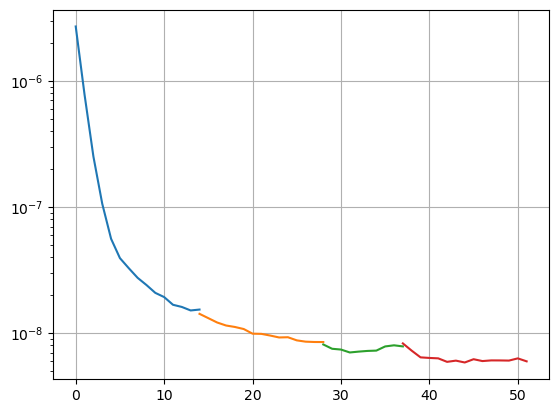

In [270]:
iter0 = np.asarray(list(range(allseq_data[0]['run_settings']['niter'])))
iter1 = np.asarray(list(range(allseq_data[1]['run_settings']['niter']))) + iter0[-1]
iter2 = np.asarray(list(range(allseq_data[2]['run_settings']['niter']))) + iter1[-1]
iter3 = np.asarray(list(range(allseq_data[3]['run_settings']['niter']))) + iter2[-1]

plt.semilogy(iter0, np.mean((np.asarray(allseq_data[0]['dh_imlist']) - allseq_data[0]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter1, np.mean((np.asarray(allseq_data[1]['dh_imlist']) - allseq_data[1]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter2, np.mean((np.asarray(allseq_data[2]['dh_imlist']) - allseq_data[2]['imbg'])[:,dh_mask], axis=-1)/norm_cps)
plt.semilogy(iter3, np.mean((np.asarray(allseq_data[3]['dh_imlist']) - allseq_data[3]['imbg'])[:,dh_mask], axis=-1)/norm_cps)

plt.grid()

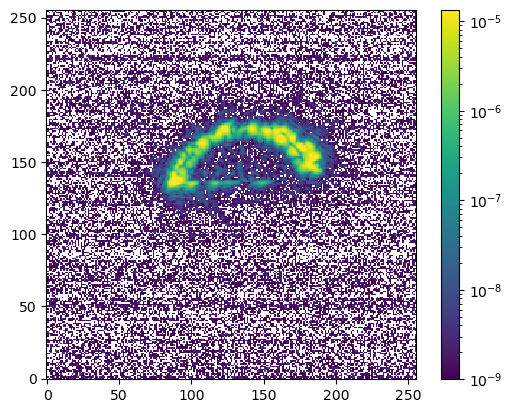

In [271]:
plt.imshow( (allseq_data[3]['dh_imlist'][-1] - allseq_data[3]['imbg'])/norm_cps, norm=LogNorm(vmin=1e-9))
plt.colorbar()

 deeper DH measurements

In [272]:
print('Setting camera')
#camstream.set_attenuation(0, wait=1)
#camstream.set_exposure_time(0.5, wait=5)

imdh = np.mean(camstream.grab_many(100),axis=0) #/ t1

print('Taking background')
imbg = take_bg(n=100, nwait=10)

Setting camera
Taking background


In [273]:
contrast_dh = np.mean((imdh-imbg)[dh_mask])/ norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, dh_mask, norm_cps))

6.046409586207226e-09
6.072074287376996e-09


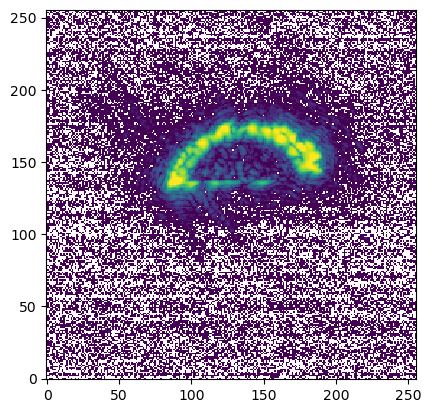

In [281]:
plt.imshow((imdh-imbg)/norm_cps, norm=LogNorm(vmin=1e-9))

In [282]:
dh_ims = {
    'imdh' : imdh,
    'imbg' : imbg,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib1_dh.h5'), dh_ims)

# DH 2

calibration parameters

In [283]:
atten = 0
#camstream.set_attenuation(atten, wait=1)
camstream.set_exposure_time(10e-3, wait=5)
t2 = camstream.get_exposure_time() * 10**(-atten/10)

In [124]:
# move field stop in!!!!
#move_relative(client, 'stagepiezo.stagefold_pos', 10) # + = in (left), - = out (right)

In [285]:
imdh = np.mean(camstream.grab_many(10),axis=0) #/ t1
contrast_dh = np.mean((imdh-imbg)[mask_dh]) / norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, mask_dh, norm_cps, rejectnegative=True))

6.339116581173807e-09
6.560659591128374e-09


In [123]:
dmch3.write(dh_cmd_good)

In [4]:
iefc.get_random_probes??

In [286]:
%%time
#iefc.zero_channels(allchbutdh)

hval = 0.0005
pval = 0.0005
num = 3
alpha = 2
fmin = 2
fmax = 14
navg = 1
dmdelay = 4 
weight = weighting0

probes2 = iefc.get_random_probes(pval, alpha, dm_mask, fmask=None, fmin=fmin, fmax=fmax, nprobe=num)#fmask

respM2, respM_combined, hmodes, hcmds = iefc.get_combined_response_matrix(camstream, dmch4, dmch5, probes2,
                                                                         hval, weight, region_slice,
                                                                         im_slice, navg=navg, dmdelay=dmdelay,
                                                                         nrepeat=1, gauss_sigma=None)

50/1024
100/1024
150/1024
200/1024
250/1024
300/1024
350/1024
400/1024
450/1024
500/1024
550/1024
600/1024
650/1024
700/1024
750/1024
800/1024
850/1024
900/1024
950/1024
1000/1024
CPU times: user 11.1 s, sys: 1.91 s, total: 13 s
Wall time: 14min 58s


In [460]:
run_settings_1 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 15,
    'dobg' : True,
}

run_settings_2 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : dh_mask,
    'reg' : 1e-9,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 7,
    'dobg' : False,
}

run_settings_3 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}

run_settings_4 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : 'residual',
    'reg' : 1e-3,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 7,
    'dobg' : True,
}

run_settings_5 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : dh_mask,
    'reg' : 1e-1,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}

run_settings_6 = {
    'atten' : 0,
    'exptime' : 20e-3,
    'mask' : dh_mask,
    'reg' : 1e-2,
    'scale' : 1.0,
    'leak' : 0.,
    'niter' : 10,
    'dobg' : False,
}


# a sequence should assume a common calibration
sequence = [run_settings_1, run_settings_2, run_settings_3,
            run_settings_4, run_settings_5, run_settings_6]

In [293]:
sequence = [run_settings_4, run_settings_5, run_settings_6,]

In [461]:
#allseq_data = {}
for i, seq in enumerate(sequence):
    
    print('Setting camera')
    camstream.set_attenuation(seq['atten'], wait=5)
    camstream.set_exposure_time(seq['exptime'], wait=5)
    
    if seq['dobg']:
        print('Taking background')
        imbg = take_bg(n=100, nwait=10)
    
    print('Recomputing control matrix')
    weight = seq['mask']
    if weight == 'residual':
        weight = dh_mask * imutils.gauss_convolve(( np.mean(camstream.grab_many(10),axis=0) - imbg )*dh_mask, 1)#**(0.5)
    respM_combined = np.concatenate([respM2[region_slice][:,n]*weight[im_slice] for n in range(num)],
                                axis=-1)
    ctrldict = control.get_control_matrix_from_hadamard_measurements(respM_combined, hmodes, hval, dm_map,
                                                                 dm_mask, wfsthresh=0.25,
                                                                 regtype='hybrid', treg=seq['reg'],
                                                                 dmthresh=0.01, ninterp=3, nmodes=951,
                                                                 deltas=True, svd_if=True)
    #iefc.display_control_matrix(ctrldict)
    
    
    print('Running iEFC')
    filter_params = {
    'fmin' : 15,
    'fmax' : 50,
    'dm_weight' : 1 - ctrldict['dmmap'] / ctrldict['dmmap'].max()
    }
    probe_imlist = []
    dh_imlist = []
    tstamp_imlist = []
    scale = seq['scale']
    leak = seq['leak']
    niter = seq['niter']
    allcmds, allresid, dh_cmd = iefc.run_iefc_cl(camstream, dmch5, dmch3, probes2, im_slice,
                                                 weight, ctrldict, dm_map, dm_mask,
                                                 niter=niter, gain=0.5*scale, leak=leak, filter_leak=True, filter_params=filter_params,
                                                 scale=1*scale, delay=0.3,
                                                 probe_imlist=probe_imlist, dh_imlist=dh_imlist, tstamp_imlist=tstamp_imlist,
                                                 threshold=None, navg=4,
                                                 dmdelay=5, bg=imbg, norm_cps=norm_cps,
                                                 nrepeat=1, reg=None)
    
    print('Consolidating data products')
    seq_dict = {
        'dh_imlist' : dh_imlist,
        'probe_imlist' : probe_imlist,
        'tstamp_imlist' : tstamp_imlist,
        'allcmds' : allcmds,
        'allresid' : allresid,
        'dh_cmd' : dh_cmd,
        'imbg' : imbg,
        'run_settings' : seq,
    }
    allseq_data[i] = seq_dict

Setting camera
Taking background
Recomputing control matrix


/tmp/ipykernel_3659988/214120274.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weight == 'residual':
INFO:control:Iteration: 1/15


Running iEFC
mean contrast: 3.4628280909221936e-09


INFO:control:Iteration: 2/15


mean contrast: 2.5837703998648083e-09


INFO:control:Iteration: 3/15


mean contrast: 2.4517651823080987e-09


INFO:control:Iteration: 4/15


mean contrast: 2.424618291404196e-09


INFO:control:Iteration: 5/15


mean contrast: 2.4285103771426683e-09


INFO:control:Iteration: 6/15


mean contrast: 2.3366310979106232e-09


INFO:control:Iteration: 7/15


mean contrast: 2.383792103344158e-09


INFO:control:Iteration: 8/15


mean contrast: 2.369103143778879e-09


INFO:control:Iteration: 9/15


mean contrast: 2.507215190423149e-09


INFO:control:Iteration: 10/15


mean contrast: 2.4064117982844823e-09


INFO:control:Iteration: 11/15


mean contrast: 2.3866256720407857e-09


INFO:control:Iteration: 12/15


mean contrast: 2.4052392870996705e-09


INFO:control:Iteration: 13/15


mean contrast: 2.359348502116349e-09


INFO:control:Iteration: 14/15


mean contrast: 2.4965485956168762e-09


INFO:control:Iteration: 15/15


mean contrast: 2.500652384763717e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/7


Running iEFC
mean contrast: 2.5369839466153106e-09


INFO:control:Iteration: 2/7


mean contrast: 2.5154716233495306e-09


INFO:control:Iteration: 3/7


mean contrast: 2.4453489405467687e-09


INFO:control:Iteration: 4/7


mean contrast: 2.402649991566545e-09


INFO:control:Iteration: 5/7


mean contrast: 2.3590553743201457e-09


INFO:control:Iteration: 6/7


mean contrast: 2.4121766449431397e-09


INFO:control:Iteration: 7/7


mean contrast: 2.4704276519996837e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 3.155939573175316e-09


INFO:control:Iteration: 2/10


mean contrast: 2.5789826458601605e-09


INFO:control:Iteration: 3/10


mean contrast: 2.5472759892375463e-09


INFO:control:Iteration: 4/10


mean contrast: 2.376105641132615e-09


INFO:control:Iteration: 5/10


mean contrast: 2.2600433187138304e-09


INFO:control:Iteration: 6/10


mean contrast: 2.3408325963228654e-09


INFO:control:Iteration: 7/10


mean contrast: 2.3585179733604404e-09


INFO:control:Iteration: 8/10


mean contrast: 2.363891982957494e-09


INFO:control:Iteration: 9/10


mean contrast: 2.4014611955041663e-09


INFO:control:Iteration: 10/10


mean contrast: 2.5151133560430604e-09
Consolidating data products
Setting camera
Taking background
Recomputing control matrix


INFO:control:Iteration: 1/7


Running iEFC
mean contrast: 2.6936164588187828e-09


INFO:control:Iteration: 2/7


mean contrast: 2.3338672284899816e-09


INFO:control:Iteration: 3/7


mean contrast: 2.337987302514389e-09


INFO:control:Iteration: 4/7


mean contrast: 2.4332212665252e-09


INFO:control:Iteration: 5/7


mean contrast: 2.4714744439296794e-09


INFO:control:Iteration: 6/7


mean contrast: 2.553289668825424e-09


INFO:control:Iteration: 7/7


mean contrast: 2.6317176391872693e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 3.044490430873663e-09


INFO:control:Iteration: 2/10


mean contrast: 2.4967322890358304e-09


INFO:control:Iteration: 3/10


mean contrast: 2.450776364542241e-09


INFO:control:Iteration: 4/10


mean contrast: 2.2657964402606397e-09


INFO:control:Iteration: 5/10


mean contrast: 2.22210411374884e-09


INFO:control:Iteration: 6/10


mean contrast: 2.392020526281125e-09


INFO:control:Iteration: 7/10


mean contrast: 2.255439258128137e-09


INFO:control:Iteration: 8/10


mean contrast: 2.2830909802366113e-09


INFO:control:Iteration: 9/10


mean contrast: 2.304131042052953e-09


INFO:control:Iteration: 10/10


mean contrast: 2.2770655755368846e-09
Consolidating data products
Setting camera
Recomputing control matrix


INFO:control:Iteration: 1/10


Running iEFC
mean contrast: 2.504907297574378e-09


INFO:control:Iteration: 2/10


mean contrast: 2.365101623663158e-09


INFO:control:Iteration: 3/10


mean contrast: 2.1335632344179943e-09


INFO:control:Iteration: 4/10


mean contrast: 2.256481490292414e-09


INFO:control:Iteration: 5/10


mean contrast: 2.2182445977655012e-09


INFO:control:Iteration: 6/10


mean contrast: 2.3110195452637214e-09


INFO:control:Iteration: 7/10


mean contrast: 2.4054555502737582e-09


INFO:control:Iteration: 8/10


mean contrast: 2.35559125516413e-09


INFO:control:Iteration: 9/10


mean contrast: 2.3566009175732736e-09


INFO:control:Iteration: 10/10


mean contrast: 2.3570080395124443e-09
Consolidating data products


save out

In [462]:
save_dict_to_h5(os.path.join(basedir, 'calib2_seq3_postbband.h5'), allseq_data)
dh_cmd_good = dh_cmd

deeper DH measurements

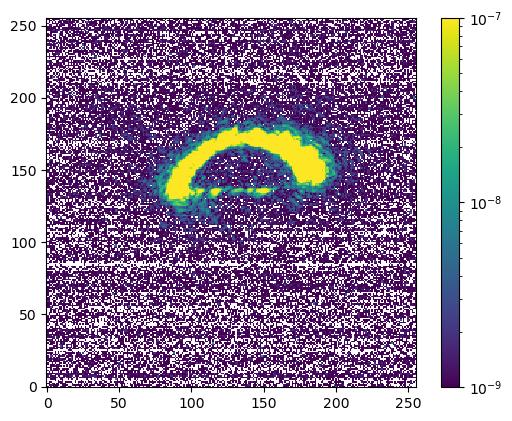

In [463]:
plt.imshow( (allseq_data[2]['dh_imlist'][-1]-allseq_data[2]['imbg']) / norm_cps, norm=LogNorm(vmin=1e-9, vmax=1e-7))
plt.colorbar()

In [297]:
#camstream.set_exposure_time(5, wait=5)

In [298]:
print('Setting camera')
#camstream.set_attenuation(0, wait=5)
#camstream.set_exposure_time(1, wait=5)

imdh = np.mean(camstream.grab_many(100),axis=0) #/ t1

print('Taking background')
imbg = take_bg(n=100, nwait=20)

Setting camera
Taking background


In [299]:
contrast_dh = np.mean((imdh-imbg)[dh_mask_proper])/ norm_cps
print(contrast_dh)
print(get_mean_contrast(imdh, imbg, dh_mask_proper, norm_cps))

2.2031377879526603e-09
2.2252999661357057e-09


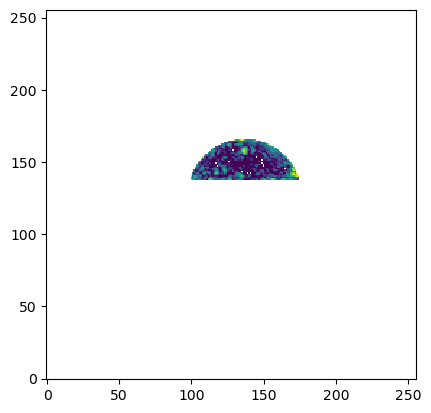

In [300]:
plt.imshow((imdh-imbg)/norm_cps*dh_mask, norm=LogNorm(vmin=1e-9))

In [301]:
dh_ims = {
    'imdh' : imdh,
    'imbg' : imbg,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh.h5'), dh_ims)

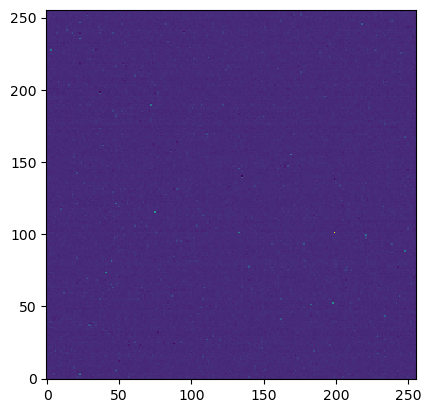

In [302]:
plt.imshow(imbg)

# Plotting

In [303]:
lambdaD_labels = [1,3,10]#[1,3,10]
im_dh = imdh
im_bg = imbg

print(np.mean( (im_dh - im_bg)[dh_mask]) / norm_cps)
print(np.median( (im_dh - im_bg)[dh_mask])  / norm_cps)
print(np.min( (im_dh - im_bg)[dh_mask])  / norm_cps)

2.6747702957082437e-09
1.7071176595264917e-09
-7.884525406461694e-10


In [137]:
#dmch3.write(dh_cmd_good)

(<Figure size 600x500 with 2 Axes>,
 <AxesSubplot: xlabel='x ($\\lambda/D$)', ylabel='y ($\\lambda/D$)'>)

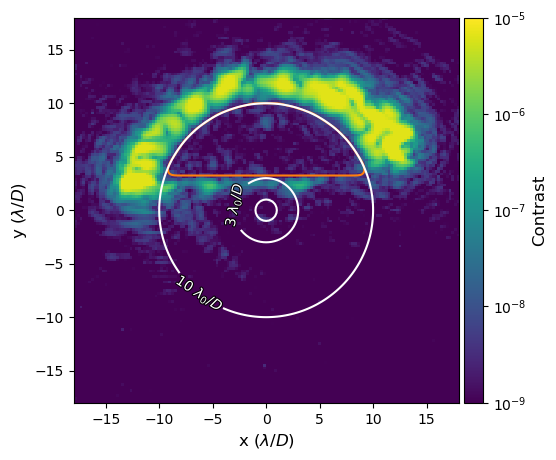

In [304]:
iefc.plot_dh((im_dh - im_bg), norm_cps, coreyx, plate_scale,
        dh_mask_proper, lambdaD_labels, vmin=1e-9, vmax=1e-5, xlim=18, ylim=18)

(<Figure size 600x500 with 2 Axes>,
 <AxesSubplot: xlabel='x ($\\lambda/D$)', ylabel='y ($\\lambda/D$)'>)

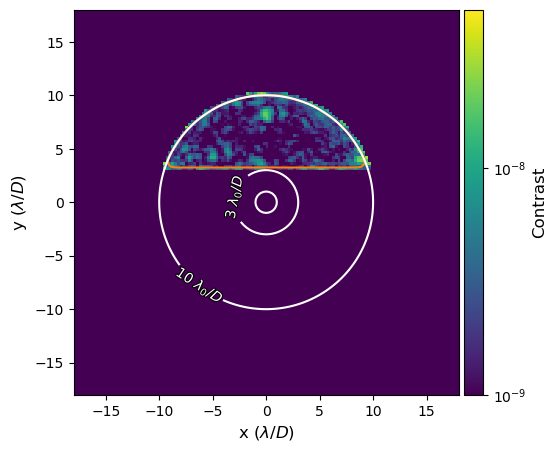

In [305]:
iefc.plot_dh(dh_mask * (im_dh - im_bg), norm_cps, coreyx, plate_scale,
        dh_mask_proper, lambdaD_labels, vmin=1e-9, vmax=5e-8, xlim=18, ylim=18)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Contrast')

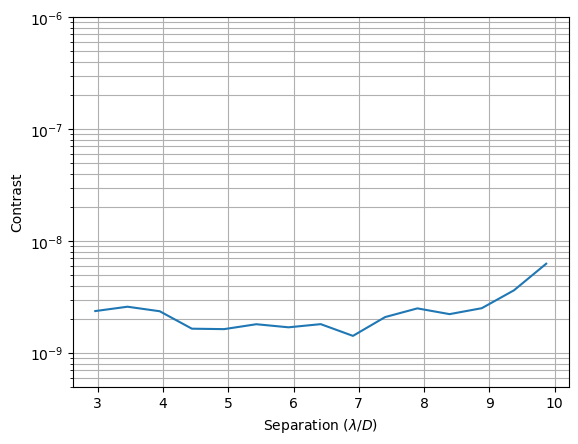

In [306]:
bins, profile_contrast = get_radial_contrast( (im_dh - im_bg) / norm_cps, mask_dh, nbins=100, cenyx=coreyx)
#profile_contrast = profile / speckle_t1 * contrast_speckle / tfactor
plt.semilogy(bins / plate_scale, profile_contrast)
plt.grid(which='both')
plt.ylim(5e-10, 1e-6)
plt.xlabel('Separation ($\lambda/D$)')
plt.ylabel('Contrast')

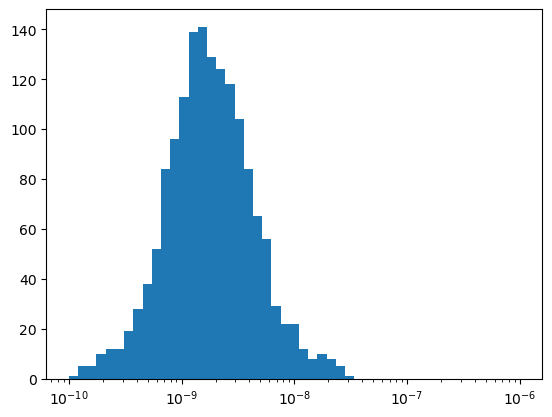

In [307]:
bins = 10**np.linspace(-10, -6, num=50)
hist = plt.hist((im_dh - im_bg)[dh_mask] / norm_cps, bins=bins)
plt.xscale('log')

wavelengths calcs

In [135]:
630*0.02

12.6

In [145]:
# 10% range is...
wmin = 630*(1-0.05)
wmax = 630*1.05

wrange = wmax-wmin

print(wmin, wmax, wrange)

w_2pcent = 630*0.02

598.5 661.5 63.0


In [144]:
nbands = 5
for n in range(nbands):
    print(wmin + w_2pcent*n, wmin + w_2pcent*(n+1))

598.5 611.1
611.1 623.7
623.7 636.3
636.3 648.9
648.9 661.5


measure contrast curves for current DH

# Other bandpasses

### narrow bands (DH images)


I'm assuming identical exposure times and camera settings for all these DHs...

In [464]:
print('Setting camera')
#camstream.set_attenuation(0, wait=1)
camstream.set_exposure_time(2, wait=5)

Setting camera


In [309]:
# get background
#imbg = take_bg(n=100, nwait=20)

In [145]:
# bands

In [310]:
#imdh_band1 = np.mean(camstream.grab_many(100),axis=0)

In [314]:
bg = np.mean(imdh_band1[:50,:])
np.mean((imdh_band1-bg)[dh_mask_proper])#/ norm_cps

31.40474895866426

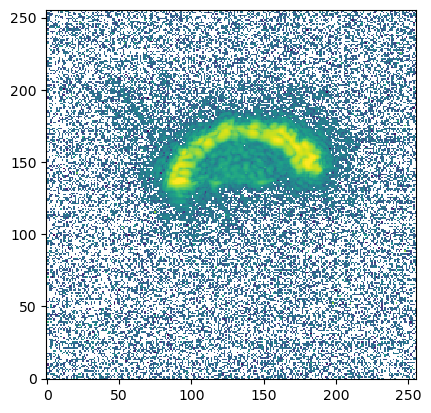

In [315]:
plt.imshow( (imdh_band1-bg), norm=LogNorm())

In [316]:
#imdh_band2 = np.mean(camstream.grab_many(100),axis=0)

In [317]:
bg = np.mean(imdh_band2[:50,:])
np.mean((imdh_band2-bg)[dh_mask_proper])#/ norm_cps

14.83449537454337

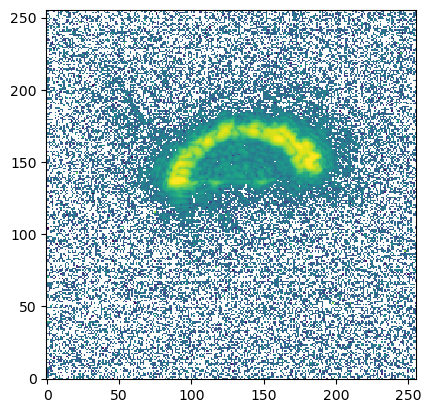

In [318]:
plt.imshow( (imdh_band2-bg), norm=LogNorm())

In [319]:
#imdh_band3 = np.mean(camstream.grab_many(100),axis=0) # 623.7 636.3

In [465]:
imdh_band3_2 = np.mean(camstream.grab_many(100),axis=0) # 623.7 636.3

8.159264634366032


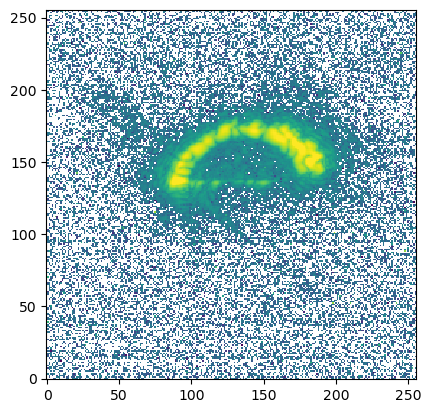

In [466]:
bg = np.mean(imdh_band3_2[:50,:])
print(np.mean((imdh_band3_2-bg)[dh_mask_proper]))
plt.imshow((imdh_band3_2-bg)/norm_cps, norm=LogNorm())

7.467073725684419


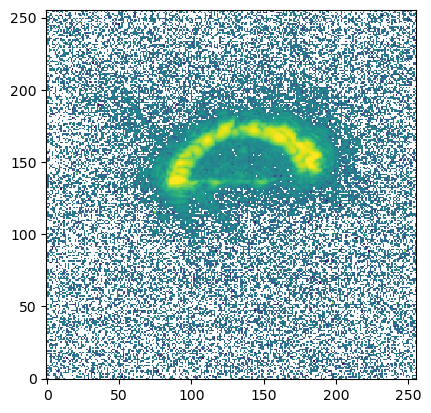

In [321]:
bg = np.mean(imdh_band3[:50,:])
print(np.mean((imdh_band3-bg)[dh_mask_proper]))
plt.imshow((imdh_band3-bg)/norm_cps, norm=LogNorm())

In [322]:
#imdh_band4 = np.mean(camstream.grab_many(100),axis=0) # 636.3 648.9

15.90230678021436


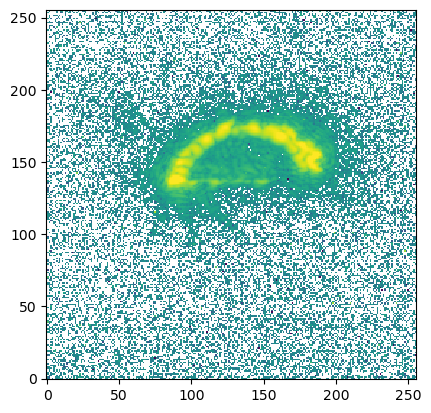

In [324]:
bg = np.mean(imdh_band4[:50,:])
print(np.mean((imdh_band4-bg)[dh_mask_proper]))
plt.imshow((imdh_band4-bg), norm=LogNorm())

In [325]:
#imdh_band5 = np.mean(camstream.grab_many(100),axis=0) # 648.9 661.5

48.3492168677954


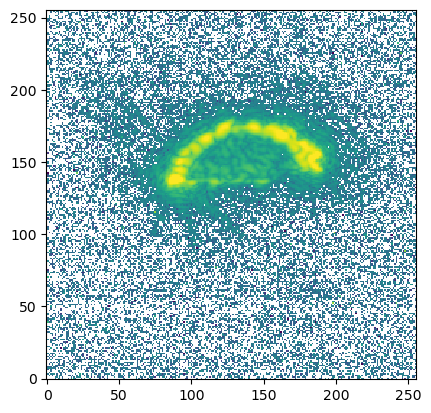

In [326]:
bg = np.mean(imdh_band5[:50,:])
print(np.mean((imdh_band5-bg)[dh_mask_proper]))
plt.imshow((imdh_band5-bg), norm=LogNorm())

In [1244]:
# broader bands centered at 630nm (DH images)

In [327]:
#imdh_5pcent = np.mean(camstream.grab_many(100),axis=0) # 614.25 645.75

In [468]:
#imdh_5pcent_2 = np.mean(camstream.grab_many(100),axis=0) # 614.25 645.75

In [328]:
#imdh_10pcent = np.mean(camstream.grab_many(100),axis=0) # 598.5 661.5

In [329]:
#imdh_15pcent = np.mean(camstream.grab_many(100),axis=0) # 582.75 677.25 

In [162]:
# common bg for all (???)
#imbg_post = take_bg(n=100, nwait=50)

In [330]:
# write out

dh_ims_band1 = {
    'imdh' : imdh_band1,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band1.h5'), dh_ims_band1)

In [331]:

dh_ims_band2 = {
    'imdh' : imdh_band2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band2.h5'), dh_ims_band2)

In [332]:

dh_ims_band3 = {
    'imdh' : imdh_band3,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band3.h5'), dh_ims_band3)

In [467]:

dh_ims_band3 = {
    'imdh' : imdh_band3_2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band3_2.h5'), dh_ims_band3)

In [333]:

dh_ims_band4 = {
    'imdh' : imdh_band4,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band4.h5'), dh_ims_band4)

In [334]:

dh_ims_band5 = {
    'imdh' : imdh_band5,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_band5.h5'), dh_ims_band5)

In [335]:

dh_ims_5pcent = {
    'imdh' : imdh_5pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_5pcent.h5'), dh_ims_5pcent)

In [469]:

dh_ims_5pcent = {
    'imdh' : imdh_5pcent_2,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_5pcent_2.h5'), dh_ims_5pcent)

In [336]:

dh_ims_10pcent = {
    'imdh' : imdh_10pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_10pcent.h5'), dh_ims_10pcent)

In [338]:
dh_ims_15pcent = {
    'imdh' : imdh_15pcent,
    'imbg' : imbg,
    #'imbg_post' : imbg_post,
    'mask' : dh_mask
}

save_dict_to_h5(os.path.join(basedir, 'calib2_dh_15pcent.h5'), dh_im6s_15pcent)

### calibration

In [472]:
# move field stop out
move_relative(client, 'stagepiezo.stagefold_pos', -50000) # + = in (left), - = out (right)

In [340]:
camstream.set_exposure_time(1e-3)

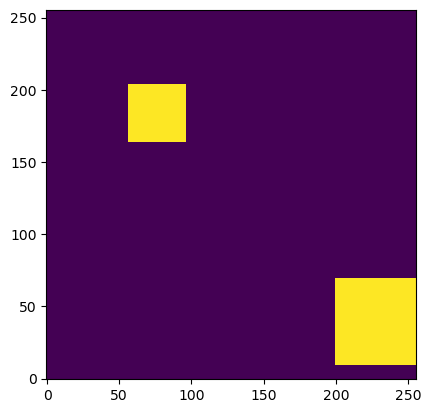

In [405]:
im_aligned = camstream.grab_latest()
shape = im_aligned.shape

mask = np.ones(shape, dtype=bool)
mask_speckle = np.zeros(shape, dtype=bool)
mask_speckle[184-20:184+20, 77-20:77+20] = 1
mask_core = np.zeros(shape, dtype=bool)
mask_core[30-20:30+40,220-20:220+40] = 1

calib_params = {
    'tilt_steps' : 60, # is this even used?
    'atten_max' : 0, #
    'atten_min' : 0,
    'gain_min' : 0,
    'gain_max' : 120,
    'cutout_extent_speckle' : 20,
    'cutout_extent_core' : 30,
    'mask_speckle' : mask_speckle,
    'mask_core' : mask_core,
    'plate_scale' : plate_scale,
    'exp_min' : 1e-4,
    'exp_max' : 10e-3,
    'exp_dh' : 10e-3
}

plt.imshow(mask_speckle + mask_core)

In [416]:
dmch3.write(dh_cmd_good)

In [470]:
move_relative(client, 'stagepiezo.stagepupil_x_pos', 200) # -34378L

In [471]:
move_relative(client, 'stagepiezo.stagepupil_y_pos', 200) # -34378L

In [343]:
camstream.set_gain(120)

In [344]:
camstream.set_exposure_time(10e-3)

In [487]:
# exp_min and gain_min should be set that off-axis core is not saturated but also such that
# at exp_max and gain_max you get high SNR on the speckle (without saturating once you max the source brightness)
camstream.set_gain(0, wait=2)
camstream.set_exposure_time(1e-4)

* √ band1
* √ band2
* √ band3
* √ band4
* √ band5
* √ 5%
* √ 10%
* 15%

In [488]:
def process_calibration_measurements(im_core, im_speckle, im_dh, calib_params, skip_conv=False):
    '''
    Use the measured attenuation in the reference speckle to determine the absolute counts per second in the core
    in the DH polarization state from the measured core in the calibration polarization state
    
    im_calibpol_tmax_gmax
    '''
    plate_scale = calib_params['plate_scale']
    
    # they're already in counts per sec
    core_calib_cps = im_core 
    speckle_calib_cps = im_speckle 
    speckle_dh_cps = im_dh
    
    # pick out the slices
    coreyx = get_core_centroid(im_core, calib_params['mask_core'])
    speckleyx = get_speckle_centroid(im_speckle, calib_params['mask_speckle'])
    
    extent_speckle = calib_params['cutout_extent_speckle']
    extent_core = calib_params['cutout_extent_core']
    speckle_slice = (slice(speckleyx[0]-extent_speckle//2, speckleyx[0]+extent_speckle//2),
                     slice(speckleyx[1]-extent_speckle//2, speckleyx[1]+extent_speckle//2))
    core_slice = (slice(coreyx[0]-extent_core//2, coreyx[0]+extent_core//2),
                  slice(coreyx[1]-extent_core//2, coreyx[1]+extent_core//2))
    print(speckle_slice, core_slice)
        
    # convolve with lambda/D gaussian(?) kernel
    apkernel = iefc.get_aperture_kernel(plate_scale, core_calib_cps.shape, oversample=16)
    
    if not skip_conv:
        core_calib_cps_apconv = imutils.convolve_fft(core_calib_cps, apkernel, force_real=True)
        speckle_calib_cps_apconv = imutils.convolve_fft(speckle_calib_cps, apkernel, force_real=True)
        speckle_dh_cps_apconv = imutils.convolve_fft(speckle_dh_cps, apkernel, force_real=True)
    else:
        core_calib_cps_apconv = core_calib_cps
        speckle_calib_cps_apconv = speckle_calib_cps
        speckle_dh_cps_apconv = speckle_dh_cps
    
    # compute the attenuation (due to gain, polarization, etc)
    atten = speckle_calib_cps_apconv[speckle_slice].max()  / speckle_dh_cps_apconv[speckle_slice].max()
    
    # compute the core CPS in the DH polarization
    core_cps_dh = core_calib_cps_apconv[core_slice].max() / atten
    
    # return all the things
    return {
        'core_slice' : core_slice,
        'speckle_slice' : speckle_slice,
        'core_calib_cps_apconv' : core_calib_cps_apconv,
        'speckle_calib_cps_apconv' : speckle_calib_cps_apconv,
        'speckle_dh_cps_apconv' : speckle_dh_cps_apconv,
        'atten' : atten,
        'core_cps_dh' : core_cps_dh,
        'coreyx' : coreyx,
        'speckleyx' : speckleyx
    }

Adjusting for non-saturated core
Taking measurements at settings for non-saturated core
Adjusting settings with known scaling for high SNR speckle measurement
Going to DH-digging settings (settings with unknown scaling) to get attenuation factor
Awaiting manual intervention (adjust to DH settings)
(slice(160, 180, None), slice(86, 106, None)) (slice(43, 73, None), slice(201, 231, None))
Attenuation factor: 0.2533248805493272
Core CPS: 1347801681.6177547
Speckle contrast: 0.00038153165040035814
Core contrast: 1.0
7.419489184786508e-10


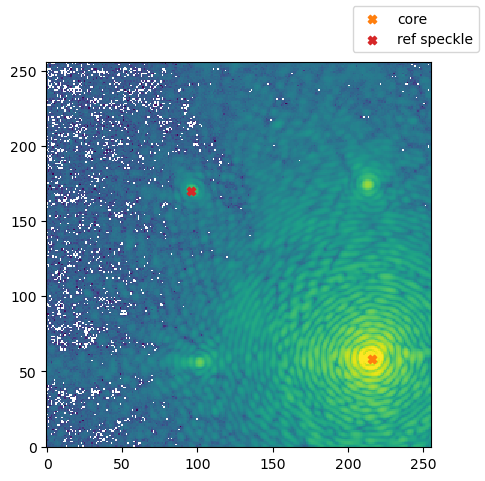

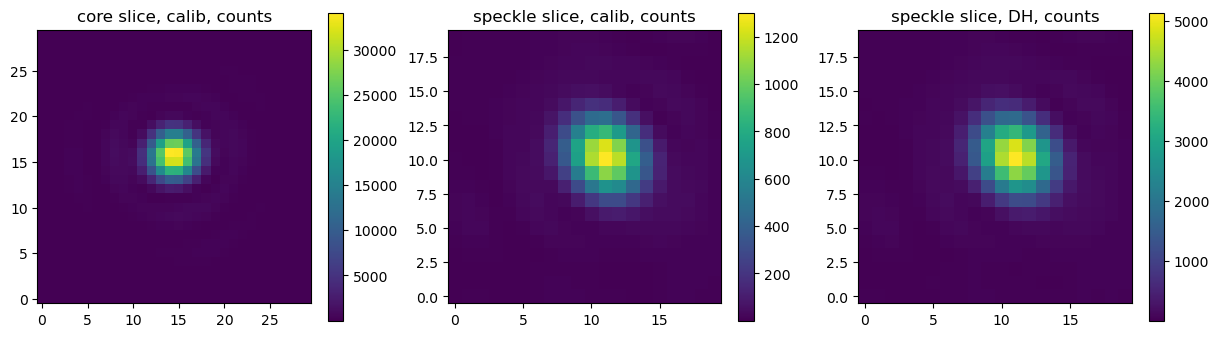

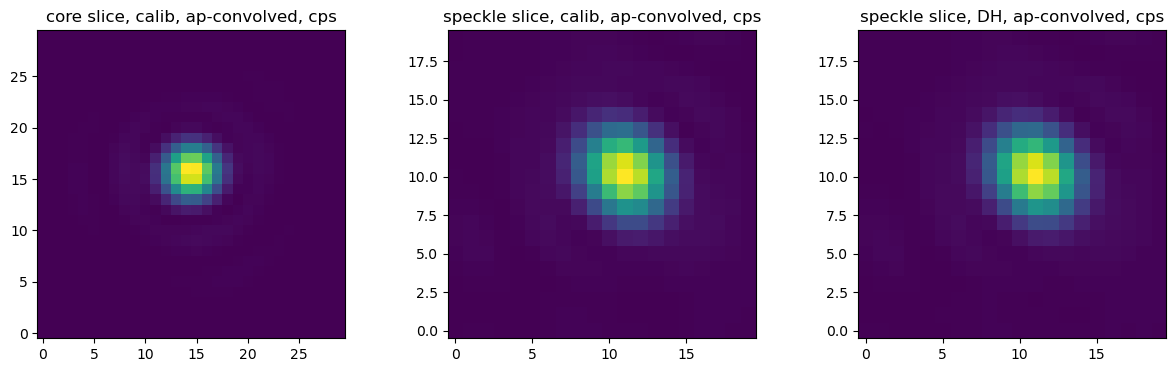

In [489]:
im_core, im_speckle, im_dh, im_core_bg, im_speckle_bg, im_dh_bg = autocalibrate_pre(im_aligned, camstream, client,
                                                                                   calib_params, satval=60000,
                                                                                    skip_fsm=True,
                                                                                   manual_intervention=True,
                                                                                   realign=False)

calib_proc = process_calibration_measurements(im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg,
                                              calib_params, skip_conv=True)

display_calibration(calib_proc, im_core-im_core_bg, im_speckle-im_speckle_bg, im_dh-im_dh_bg)

norm_cps = calib_proc['core_cps_dh']
print(1/norm_cps)

6.053757571048982e-09


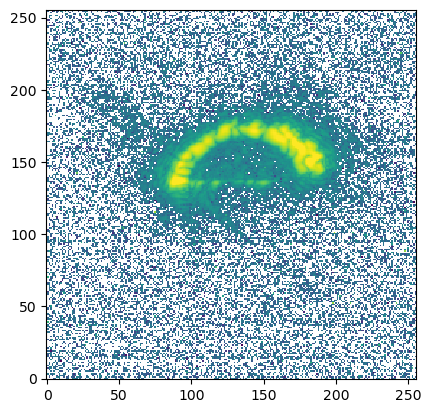

In [495]:
imdh_cur = imdh_band3_2#imdh_band3_2

bg = np.mean(imdh_cur[:50,:])
print(np.mean( (imdh_cur-bg)[dh_mask_proper])/norm_cps)
plt.imshow((imdh_cur-bg)/norm_cps, norm=LogNorm())

In [491]:
imutils.rms(dh_cmd, dm_mask) * 1e3

14.679827727377415

In [492]:
allcalib = {
    'calib_params' : calib_params,
    'calib_proc' : calib_proc,
    'im_core' : im_core,
    'im_speckle' : im_speckle,
    'im_dh' : im_dh,
    'im_core_bg' : im_core_bg,
    'im_speckle_bg' : im_speckle_bg,
    'im_dh_bg' : im_dh_bg,
}

save_dict_to_h5(os.path.join(basedir, 'allcalib_band3_2.h5'), allcalib)

In [493]:
ls iefc_2024_05_30_NKT_2pcent_andfriends_NSV571_BeamCoSubstrateVVC_aeroglazeLS_vacuum

allcalib_10pcent.h5   allcalib_band5.h5      calib2_dh_band2.h5
allcalib_15pcent.h5   allcalib.h5            calib2_dh_band3_2.h5
allcalib_5pcent_2.h5  calib1_dh.h5           calib2_dh_band3.h5
allcalib_5pcent.h5    calib1_seq.h5          calib2_dh_band4.h5
allcalib_band1.h5     calib2_dh_10pcent.h5   calib2_dh_band5.h5
allcalib_band2.h5     calib2_dh_15pcent.h5   calib2_dh.h5
allcalib_band3_2.h5   calib2_dh_5pcent_2.h5  calib2_seq2.h5
allcalib_band3.h5     calib2_dh_5pcent.h5    calib2_seq3_postbband.h5
allcalib_band4.h5     calib2_dh_band1.h5     calib2_seq.h5
